In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [60]:
def integrate(T, f): 
    tot = 0;
    for i in range(len(T)-1):
        tot = tot + (1/2 * (f[i]+f[i+1]) * (T[1]-T[0]))
    return tot

def proj(K,T,T0,f): #returns error and projection
    up_idx = int(np.where(T==T0[-1])[0])
    dw_idx = int(np.where(T==T0[0])[0])
    K_tau_tau = K[dw_idx:up_idx,dw_idx:up_idx]
    K_tau = K[dw_idx:up_idx,:]
    beta_tau = beta[dw_idx:up_idx] 
    
    a = np.linalg.solve(np.linalg.inv(K_tau_tau),beta_tau)
    error = np.dot(a,K_tau_tau)-beta_tau
    proj = beta-np.dot(a,K_tau)
    
    return error, proj

def get_K0(K,T,T0):
    up_idx = int(np.where(T==T0[-1])[0])
    dw_idx = int(np.where(T==T0[0])[0])
    K_tau_tau = K[dw_idx:up_idx,dw_idx:up_idx]
    K_tau = K[dw_idx:up_idx,:]
    
    return K - np.dot(np.dot(K_tau.T,np.linalg.inv(K_tau_tau)),K_tau)

class data_generator:
    def __init__(self, T, T0, g, beta, n, covariates_kernel, sigma):
        self.g = g
        self.T = T
        self.K = np.fromfunction(np.vectorize(lambda s, t: covariates_kernel(self.T[s], self.T[t])), (g, g), dtype=int)
        self.g = g
        self.n = n
        self.beta = beta
        self.sigma = sigma
        self.T0 = T0
    
    def grid(self):
        return self.T
    
    def i_o(self):
        x = np.random.multivariate_normal(np.zeros(self.g), self.K, self.n)
        y = np.fromfunction(np.vectorize(lambda i: integrate(self.T,  x[i,:]*beta)+np.random.normal(0,self.sigma,1)), (self.n,), dtype=int)
        return x,y
    
    def get_T0(self):
        return self.T0

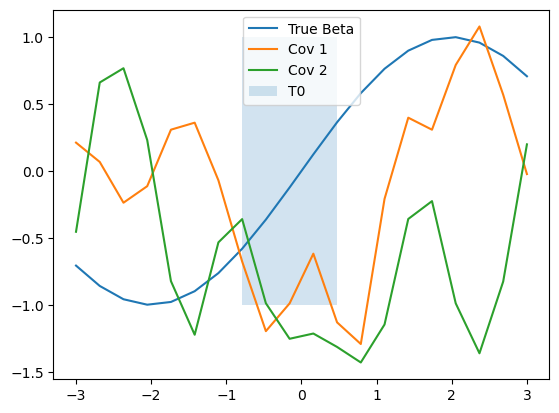

In [64]:
# EXAMPLE
# input
a = -3
b = 3
g = 20
T = np.linspace(a,b,g)
T0 = T[np.where((T<0.5)&(T>-1))]
n = 100
sigma = 1
beta = np.sin(np.linspace(a,b,g)*np.pi/4)
def covariates_kernel(s,t):
    return np.exp(-2*(t-s)**2)
def prior_kernel(s,t):
    return np.exp(-(t-s)**2)

#generation
data = data_generator(T,T0,g,beta,n,covariates_kernel, sigma)
x,y = data.i_o()

plt.plot(T,beta,label='True Beta')
plt.plot(T,x[0,:],label='Cov 1')
plt.plot(T,x[1,:],label='Cov 2')
plt.fill_betweenx(y=[-1, 1], x1 = T0[0], x2 = T0[-1],alpha=0.2,label='T0')
plt.legend()

In [65]:
class posterior:
    def __init__(self, T, T0, x, y, prior_kernel,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.prior_kernel = prior_kernel
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.T0 = T0
        self.sigma = sigma
        self.K = np.fromfunction(np.vectorize(lambda s, t: self.prior_kernel(self.T[s], self.T[t])), (self.g, self.g), dtype=int)
        self.K0 = get_K0(self.K,self.T,self.T0)
    
    def getter(self):
        return self.K0
        
    def Lx0(self,t):   
        L = np.zeros(self.n)    
        for i in np.arange(0,self.n):
            L[i] = integrate(self.T,self.K0[t, :] * self.x[i,:])
        return L
    
    def R0(self,i, j):
        Ri = np.fromfunction(np.vectorize(lambda t: integrate(self.T,self.K0[:,t] * self.x[i,:])), (self.g,), dtype=int)
        Rij = integrate(self.T, Ri * self.x[j,:])
        return  Rij
    
    def M(self):
        return np.fromfunction(np.vectorize(lambda i, j: self.R0(i, j)), (self.n, self.n), dtype=int)+np.identity(self.n)
    
    def posterior_mean_cov(self):
        inv = np.linalg.inv(self.M())
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)),inv),self.y)
            return mean
        def Kstar(s,t):
            cov = (self.sigma**2)*(self.K0[s,t] - np.dot(np.dot(np.transpose(self.Lx0(s)),inv),self.Lx0(t)))
            return cov
        
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        C = np.fromfunction(np.vectorize(lambda t, s: Kstar(s,t)), (self.g,self.g), dtype=int)
        return m,C
    
    def only_mean(self):
        inv = np.linalg.inv(self.M())
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx0(t)),inv),self.y)
            return mean
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        return m
    
    def fitted_values(self):
        m = self.only_mean()
        return np.fromfunction(np.vectorize(lambda i: integrate(T, self.x[i,:]*m)), (self.n,), dtype=int)


In [66]:
p = posterior(T,T0,x,y,prior_kernel,sigma)
m, cov = p.posterior_mean_cov()

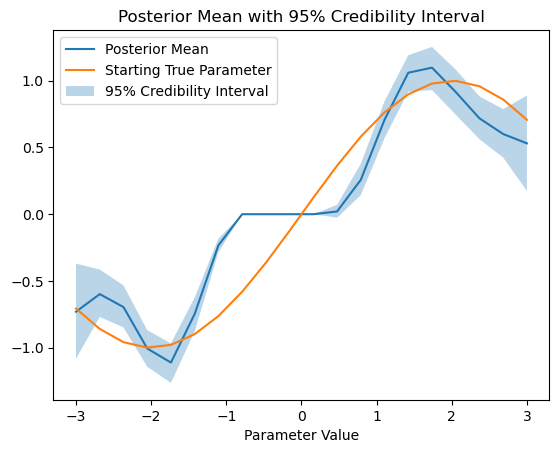

In [67]:
samples = np.random.multivariate_normal(m, cov, size=1000)

up = np.zeros(m.shape[0])
down = np.zeros(m.shape[0])
for i in range(m.shape[0]):
    mean, var, std = scipy.stats.bayes_mvs(samples[:,i], alpha=0.95)
    mean_estimate, std_estimate = mean.statistic, std.statistic
    down[i],up[i] = mean_estimate - std_estimate, mean_estimate + std_estimate 



plt.plot(T,m, label='Posterior Mean')
plt.plot(T,beta, label='Starting True Parameter')
plt.fill_between(T, down, up, alpha=0.3, label='95% Credibility Interval')

plt.title('Posterior Mean with 95% Credibility Interval')
plt.xlabel('Parameter Value')
plt.legend()
plt.show()